# Load Train data  

In [1]:
from nuscenes import NuScenes
# import visdom
# import my_util as mu
# vis = visdom.Visdom()

# This is the path where you stored your copy of the nuScenes dataset.
DATAROOT = '/home/dhpark/Data/nuscenes-v1.0/full_dataset/mini'

nuscenes = NuScenes('v1.0-mini', dataroot=DATAROOT)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.315 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [2]:
from nuscenes.eval.prediction.splits import get_prediction_challenge_split
mini_train = get_prediction_challenge_split("mini_train", dataroot=DATAROOT)
print(len(mini_train))
print(mini_train[:5])

mini_val = get_prediction_challenge_split("mini_val", dataroot=DATAROOT)
print(len(mini_val))
print(mini_val[:5])

742
['bc38961ca0ac4b14ab90e547ba79fbb6_39586f9d59004284a7114a68825e8eec', 'bc38961ca0ac4b14ab90e547ba79fbb6_356d81f38dd9473ba590f39e266f54e5', 'bc38961ca0ac4b14ab90e547ba79fbb6_e0845f5322254dafadbbed75aaa07969', 'bc38961ca0ac4b14ab90e547ba79fbb6_c923fe08b2ff4e27975d2bf30934383b', 'bc38961ca0ac4b14ab90e547ba79fbb6_f1e3d9d08f044c439ce86a2d6fcca57b']
61
['dc762bf1bc694d3e8141bf592f9b1456_c5f58c19249d4137ae063b0e9ecd8b8e', 'dc762bf1bc694d3e8141bf592f9b1456_700c1a25559b4433be532de3475e58a9', 'dc762bf1bc694d3e8141bf592f9b1456_747aa46b9a4641fe90db05d97db2acea', 'dc762bf1bc694d3e8141bf592f9b1456_f4f86af4da3b49e79497deda5c5f223a', 'dc762bf1bc694d3e8141bf592f9b1456_6832e717621341568c759151b5974512']


## Rasterize Data

## Data Loader

In [3]:
from PIL import Image
import torch
import torchvision.transforms as transforms

img = Image.open('./my_data/train/image/0ba56cee062b419a80a6a90302944c19_3ff58ee0fc4748d9895300f02114aa56.jpg').convert('RGB')
imgtens = transforms.ToTensor()(img)
print(imgtens.shape)

state = torch.load('./my_data/train/state/0ba56cee062b419a80a6a90302944c19_3ff58ee0fc4748d9895300f02114aa56.state')
print(state.squeeze(0).shape)

gt = torch.load('./my_data/train/traj/0ba56cee062b419a80a6a90302944c19_3ff58ee0fc4748d9895300f02114aa56.traj')
print(gt.shape)

torch.Size([3, 500, 500])
torch.Size([3])
torch.Size([12, 2])


In [4]:
from PIL import Image
import os
import os.path
import torch.utils.data
import torchvision.transforms as transforms
import numpy as np
import torch
    
class DataSet(torch.utils.data.Dataset):
    def __init__(self, dataroot, split):
        if split == 'mini_train':
            dataroot = os.path.join(dataroot, 'train')
            fns = mini_train
        elif split == 'mini_val':
            dataroot = os.path.join(dataroot, 'val')
            fns = mini_val
        else:
            raise NameError('split should be "mini_train" or "mini_val", or be declared')

        self.dataroot = dataroot
        self.fns = fns
        self.split = split
    
    def __getitem__(self, index):
        fn = self.fns[index]
        image = Image.open(os.path.join(self.dataroot, 'image', fn+'.jpg'))
        image = transforms.ToTensor()(image)
        agent_state_vector = torch.load(os.path.join(self.dataroot, 'state', fn+'.state')).squeeze(0)
        ground_truth = torch.load(os.path.join(self.dataroot, 'traj', fn+'.traj'))
        
        return image, agent_state_vector, ground_truth
        
    def __len__(self):
        return len(self.fns)


In [5]:
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

dataset = DataSet('/home/dhpark/Projects/nuscenes-devkit/my_data', 'mini_train')
dataloader = DataLoader(dataset, batch_size=32, num_workers=0)

cuda:0


In [6]:
import torch.optim as optim
import numpy as np

from nuscenes.prediction.models.backbone import ResNetBackbone
from nuscenes.prediction.models.mtp import MTP, MTPLoss
from tqdm import tqdm

num_modes = 2

backbone = ResNetBackbone('resnet18')
model = MTP(backbone, num_modes)
model = model.to(device)

loss_function = MTPLoss(num_modes, 1, 5)

current_loss = 10000

optimizer = optim.SGD(model.parameters(), lr=0.1)

n_iter = 0

minimum_loss = 0

if num_modes == 2:

    # We expect to see 75% going_forward and
    # 25% going backward. So the minimum
    # classification loss is expected to be
    # 0.56234

    minimum_loss += 0.56234
while True:
    loss_mean = []
    for img, agent_state_vector, ground_truth in dataloader:

        img[img != img] = 0
        agent_state_vector[agent_state_vector != agent_state_vector] = 0
        ground_truth[ground_truth != ground_truth] = 0

        img = img.to(device)
        agent_state_vector = agent_state_vector.to(device)
        ground_truth = ground_truth.to(device)

        optimizer.zero_grad()

        prediction = model(img, agent_state_vector)

        loss = loss_function(prediction, ground_truth.unsqueeze(1))

        # loss = loss_function(prediction, ground_truth)
        loss.backward()
        optimizer.step()

        current_loss = loss.cpu().detach().numpy()
        loss_mean.append(current_loss.item())
#     ep_loss = np.mean(loss_mean)
        print(f"Current loss is {current_loss:.4f} @ ep {n_iter:d}")
        if np.allclose(current_loss, minimum_loss, atol=1e-4):
            print(f"Achieved near-zero loss after {n_iter} iterations.")
            torch.save(model.state_dict(), './model_weight.pth')
            break

    n_iter += 1

Current loss is 10.3104 @ ep 0
Current loss is 16.5792 @ ep 0
Current loss is 39.1519 @ ep 0


KeyboardInterrupt: 

torch.save(model.state_dict(), './model_weight.pth')

In [7]:
idx=10
img_test = img[idx].to('cpu')
agent_state_vector_test = agent_state_vector[idx].to('cpu')
ground_truth_test = ground_truth[idx].to('cpu')

model_test = model.to('cpu')
model_test.load_state_dict(torch.load('./model_weight.pth'))
prediction_test = model_test(img_test.unsqueeze(0), agent_state_vector_test.unsqueeze(0))

img_test_pil = transforms.ToPILImage()(img_test)

In [9]:
from my_util import drawtraj
import cv2
img_test_t = np.asarray(img_test).transpose(1,2,0)
img_test_t = cv2.cvtColor(img_test_t, cv2.COLOR_RGB2BGR)
# a = drawtraj(img_test_t, prediction_test)


In [14]:
num_modes=2
img_show = img_test_t
trajs, probs = prediction_test[:,:-num_modes], prediction_test[:,-num_modes:]
trajs, probs = np.array_split(trajs.detach().numpy(), num_modes, axis=1), np.array_split(probs.detach().numpy(), num_modes, axis=1) 


for traj, prob in zip(trajs, probs):
#     traj = np.asarray(ground_truth_test).reshape(-1,24)
    x, y = 400, 250
    cv2.circle(img_show, (int(y), int(x)), 2, (0,0,255), 2)
    for disp in np.array_split(traj, 12, axis=1):
        p1 = (int(y),int(x))
        x -= disp[0][1] * 1
        y += disp[0][0] * 1
        p2 = (int(y),int(x))

        cv2.line(img_show, p1, p2, (255,0,255), 1 )
        cv2.circle(img_show, (int(y), int(x)), 2, (0,0,255), 2)

    cv2.putText(img_show, '%.2f' % prob, p2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 3)
    cv2.putText(img_show, '%.2f' % prob, p2, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 2)

In [15]:
ground_truth_test

tensor([[-0.0803,  4.5764],
        [-0.2208,  9.1357],
        [-0.4431, 13.0711],
        [-0.7773, 16.9947],
        [-1.1239, 20.1242],
        [-1.6563, 24.0253],
        [-2.2998, 27.9095],
        [-3.0083, 31.4279],
        [-3.1036, 33.6696],
        [-3.6781, 37.2357],
        [-4.4665, 39.5555],
        [-4.6681, 42.0376]])

In [16]:
traj
for disp in np.array_split(traj, 12, axis=1):
    print(disp)

[[-0.37751493  1.6157596 ]]
[[-0.4037865  5.229689 ]]
[[-0.2796116 10.801151 ]]
[[-0.11399769 18.517654  ]]
[[ 0.04594296 27.077835  ]]
[[ 0.12412466 36.18239   ]]
[[ 0.19524324 46.06127   ]]
[[ 0.27979058 56.266903  ]]
[[ 0.4327102 66.70913  ]]
[[ 0.6301296 77.63253  ]]
[[ 0.8725671 88.4505   ]]
[[ 1.1440301 99.398796 ]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


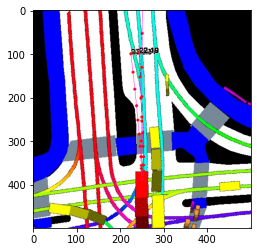

In [17]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()